# Retrieval Augmented Question & Answering with Amazon Bedrock using LangChain

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

### Context
Previously we saw that the model told us how to to change the tire, however we had to manually provide it with the relevant data and provide the contex ourselves. We explored the approach to leverage the model availabe under Bedrock and ask questions based on it's knowledge learned during training as well as providing manual context. While that approach works with short documents or single-ton applications, it fails to scale to enterprise level question answering where there could be large enterprise documents which cannot all be fit into the prompt sent to the model. 

### Pattern
We can improve upon this process by implementing an architecure called Retreival Augmented Generation (RAG). RAG retrieves data from outside the language model (non-parametric) and augments the prompts by adding the relevant retrieved data in context. 

In this notebook we explain how to approach the pattern of Question Answering to find and leverage the documents to provide answers to the user questions.

### Challenges
- How to manage large document(s) that exceed the token limit
- How to find the document(s) relevant to the question being asked

### Proposal
To the above challenges, this notebook proposes the following strategy
#### Prepare documents
![Embeddings](./images/Embeddings_lang.png)

Before being able to answer the questions, the documents must be processed and a stored in a document store index
- Load the documents
- Process and split them into smaller chunks
- Create a numerical vector representation of each chunk using Amazon Bedrock Titan Embeddings model
- Create an index using the chunks and the corresponding embeddings
#### Ask question
![Question](./images/Chatbot_lang.png)

When the documents index is prepared, you are ready to ask the questions and relevant documents will be fetched based on the question being asked. Following steps will be executed.
- Create an embedding of the input question
- Compare the question embedding with the embeddings in the index
- Fetch the (top N) relevant document chunks
- Add those chunks as part of the context in the prompt
- Send the prompt to the model under Amazon Bedrock
- Get the contextual answer based on the documents retrieved

## Use Case
#### Dataset
To explain this architecture pattern we are using the documents from IRS. These documents explain topics such as:
- Original Issue Discount (OID) Instruments
- Reporting Cash Payments of Over $10,000 to IRS
- Employer's Tax Guide

#### Persona
Let's assume a persona of a layman who doesn't have an understanding of how IRS works and if some actions have implications or not.

The model will try to answer from the documents in easy language.


## Implementation
In order to follow the RAG approach this notebook is using the LangChain framework where it has integrations with different services and tools that allow efficient building of patterns such as RAG. We will be using the following tools:

- **LLM (Large Language Model)**: Anthropic Claude V1 available through Amazon Bedrock

  This model will be used to understand the document chunks and provide an answer in human friendly manner.
- **Embeddings Model**: Amazon Titan Embeddings available through Amazon Bedrock

  This model will be used to generate a numerical representation of the textual documents
- **Document Loader**: PDF Loader available through LangChain

  This is the loader that can load the documents from a source, for the sake of this notebook we are loading the sample files from a local path. This could easily be replaced with a loader to load documents from enterprise internal systems.

- **Vector Store**: FAISS available through LangChain

  In this notebook we are using this in-memory vector-store to store both the embeddings and the documents. In an enterprise context this could be replaced with a persistent store such as AWS OpenSearch, RDS Postgres with pgVector, ChromaDB, Pinecone or Weaviate.
- **Index**: VectorIndex

  The index helps to compare the input embedding and the document embeddings to find relevant document
- **Wrapper**: wraps index, vector store, embeddings model and the LLM to abstract away the logic from the user.

## Setup

⚠️ ⚠️ ⚠️ Before running this notebook, ensure you've run the [Bedrock boto3 setup notebook](../00_Intro/bedrock_boto3_setup.ipynb#Prerequisites) notebook. ⚠️ ⚠️ ⚠️


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install langchain>=0.1.11
%pip install pypdf==4.1.0
%pip install langchain-community faiss-cpu==1.8.0 tiktoken==0.6.0 sqlalchemy==2.0.28


zsh:1: 0.1.11 not found
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
import json
import os
import sys

import boto3
import botocore

boto3_bedrock = boto3.client('bedrock-runtime', region_name='us-east-1')

In [28]:
import warnings

from io import StringIO
import sys
import textwrap
import os
from typing import Optional

# External Dependencies:
import boto3
from botocore.config import Config

warnings.filterwarnings('ignore')

def print_ww(*args, width: int = 100, **kwargs):
    """Like print(), but wraps output to `width` characters (default 100)"""
    buffer = StringIO()
    try:
        _stdout = sys.stdout
        sys.stdout = buffer
        print(*args, **kwargs)
        output = buffer.getvalue()
    finally:
        sys.stdout = _stdout
    for line in output.splitlines():
        print("\n".join(textwrap.wrap(line, width=width)))
        

## Configure langchain

We begin with instantiating the LLM and the Embeddings model. Here we are using Anthropic Claude for text generation and Amazon Titan for text embedding.

Note: It is possible to choose other models available with Bedrock. You can replace the `model_id` as follows to change the model.

`llm = Bedrock(model_id="amazon.titan-text-express-v1")`

Check [documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids-arns.html) for Available text generation and embedding models Ids under Amazon Bedrock.

In [29]:
# We will be using the Titan Embeddings Model to generate our Embeddings.
from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock

# - create the Anthropic Model
llm = Bedrock(model_id="amazon.titan-tg1-large", client=boto3_bedrock, model_kwargs={'max_tokens_to_sample':200})
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=boto3_bedrock)

## Data Preparation
Let's first download some of the files to build our document store. For this example we will be using public IRS documents from [here](https://www.irs.gov/publications).

In [30]:
from urllib.request import urlretrieve

os.makedirs("data", exist_ok=True)
files = [
    "https://www.irs.gov/pub/irs-pdf/p1544.pdf",
    "https://www.irs.gov/pub/irs-pdf/p15.pdf",
    "https://www.irs.gov/pub/irs-pdf/p1212.pdf",
]
for url in files:
    file_path = os.path.join("data", url.rpartition("/")[2])
    urlretrieve(url, file_path)

After downloading we can load the documents with the help of [DirectoryLoader from PyPDF available under LangChain](https://python.langchain.com/en/latest/reference/modules/document_loaders.html) and splitting them into smaller chunks.

Note: The retrieved document/text should be large enough to contain enough information to answer a question; but small enough to fit into the LLM prompt. Also the embeddings model has a limit of the length of input tokens limited to 8192 tokens, which roughly translates to ~32,000 characters. For the sake of this use-case we are creating chunks of roughly 1000 characters with an overlap of 100 characters using [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/modules/indexes/text_splitters/examples/recursive_text_splitter.html).

In [31]:
import numpy as np
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
#from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from langchain_community.document_loaders.pdf import PyPDFLoader, PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("./data/")

documents = loader.load()
# - in our testing Character split works better with this PDF data set
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1000,
    chunk_overlap  = 100,
)
docs = text_splitter.split_documents(documents)

In [32]:
avg_doc_length = lambda documents: sum([len(doc.page_content) for doc in documents])//len(documents)
avg_char_count_pre = avg_doc_length(documents)
avg_char_count_post = avg_doc_length(docs)
print(f'Average length among {len(documents)} documents loaded is {avg_char_count_pre} characters.')
print(f'After the split we have {len(docs)} documents more than the original {len(documents)}.')
print(f'Average length among {len(docs)} documents (after split) is {avg_char_count_post} characters.')

Average length among 81 documents loaded is 5889 characters.
After the split we have 560 documents more than the original 81.
Average length among 560 documents (after split) is 912 characters.


We had 3 PDF documents which have been split into smaller ~500 chunks.

Now we can see how a sample embedding would look like for one of those chunks

In [33]:
try:
    
    sample_embedding = np.array(bedrock_embeddings.embed_query(docs[0].page_content))
    print("Sample embedding of a document chunk: ", sample_embedding)
    print("Size of the embedding: ", sample_embedding.shape)

except ValueError as error:
    if  "AccessDeniedException" in str(error):
        print(f"\x1b[41m{error}\
        \nTo troubeshoot this issue please refer to the following resources.\
         \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
         \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")      
        class StopExecution(ValueError):
            def _render_traceback_(self):
                pass
        raise StopExecution        
    else:
        raise error

Sample embedding of a document chunk:  [ 0.11621094  0.06494141 -0.23730469 ...  0.11962891 -0.29882812
 -0.27929688]
Size of the embedding:  (1536,)


Following the similar pattern embeddings could be generated for the entire corpus and stored in a vector store.

This can be easily done using [FAISS](https://github.com/facebookresearch/faiss) implementation inside [LangChain](https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/faiss.html) which takes  input the embeddings model and the documents to create the entire vector store. Using the Index Wrapper we can abstract away most of the heavy lifting such as creating the prompt, getting embeddings of the query, sampling the relevant documents and calling the LLM. [VectorStoreIndexWrapper](https://python.langchain.com/en/latest/modules/indexes/getting_started.html#one-line-index-creation) helps us with that.

**⚠️⚠️⚠️ NOTE: it might take few minutes to run the following cell ⚠️⚠️⚠️**

In [34]:
from langchain.chains.question_answering import load_qa_chain
from langchain.vectorstores import FAISS
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

vectorstore_faiss = FAISS.from_documents(
    docs,
    bedrock_embeddings,
)

wrapper_store_faiss = VectorStoreIndexWrapper(vectorstore=vectorstore_faiss)

## Question Answering

Now that we have our vector store in place, we can start asking questions.

In [35]:
query = """Is it possible that I get sentenced to jail due to failure in filings?"""

The first step would be to create an embedding of the query such that it could be compared with the documents

In [36]:
query_embedding = vectorstore_faiss.embedding_function.embed_query(query)
np.array(query_embedding)

array([-0.18066406,  0.25976562, -0.09082031, ...,  0.3984375 ,
       -0.58984375, -0.27148438])

We can use this embedding of the query to then fetch relevant documents.
Now our query is represented as embeddings we can do a similarity search of our query against our data store providing us with the most relevant information.

In [37]:
relevant_documents = vectorstore_faiss.similarity_search_by_vector(query_embedding)
print(f'{len(relevant_documents)} documents are fetched which are relevant to the query.')
print('----')
for i, rel_doc in enumerate(relevant_documents):
    print_ww(f'## Document {i+1}: {rel_doc.page_content}.......')
    print('---')

4 documents are fetched which are relevant to the query.
----
## Document 1: There are civil penalties for failure to:
File a correct Form 8300 by the date it is
due, and
Provide the required statement to those
named in the Form 8300.
If you intentionally disregard the requirement
to file a correct Form 8300 by the date it is due,
the penalty is the greater of:
1.$25,000, or
2.The amount of cash you received and
were required to report (up to $100,000).
There are criminal penalties for:
Willful failure to file Form 8300,
Willfully filing a false or fraudulent Form
8300,
Stopping or trying to stop Form 8300 from
being filed, and
Setting up, helping to set up, or trying to
set up a transaction in a way that would
make it seem unnecessary to file Form
8300.
If you willfully fail to file Form 8300, you can
be fined up to $250,000 for individuals
RECORDS($500,000 for corporations) or sentenced to up
to 5 years in prison, or both. These dollar
amounts are based on Section 3571 of Title 18
of

Now we have the relevant documents, it's time to use the LLM to generate an answer based on these documents. 

We will take our inital prompt, together with our relevant documents which were retreived based on the results of our similarity search. We then by combining these create a prompt that we feed back to the model to get our result. At this point our model should give us highly informed information on how we can change the tire of our specific car as it was outlined in our manual.

LangChain provides an abstraction of how this can be done easily.

### Quick way
You have the possibility to use the wrapper provided by LangChain which wraps around the Vector Store and takes input the LLM.
This wrapper performs the following steps behind the scences:
- Take the question as input
- Create question embedding
- Fetch relevant documents
- Stuff the documents and the question into a prompt
- Invoke the model with the prompt and generate the answer in a human readable manner.

In [38]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
prompt_template = """

Human: Use the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
<context>
{context}
</context

Question: {question}

Assistant:"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

In [40]:
llm = Bedrock(model_id='amazon.titan-tg1-large', client=boto3_bedrock)
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore_faiss.as_retriever(
        search_type="similarity", search_kwargs={"k": 3}
    ),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)
answer = qa({"query": query})
print_ww(answer)

{'query': 'Is it possible that I get sentenced to jail due to failure in filings?', 'result': ' Yes,
it is possible. The penalty may include a sentence of up to five years in jail.',
'source_documents': [Document(metadata={'source': 'data/p1544.pdf', 'page': 3}, page_content='There
are civil penalties for failure to:\nFile a correct Form 8300 by the date it is \ndue, and\nProvide
the required statement to those \nnamed in the Form 8300.\nIf you intentionally disregard the
requirement \nto file a correct Form 8300 by the date it is due, \nthe penalty is the greater
of:\n1.$25,000, or\n2.The amount of cash you received and \nwere required to report (up to
$100,000).\nThere are criminal penalties for:\nWillful failure to file Form 8300,\nWillfully filing
a false or fraudulent Form \n8300,\nStopping or trying to stop Form 8300 from \nbeing filed,
and\nSetting up, helping to set up, or trying to \nset up a transaction in a way that would \nmake
it seem unnecessary to file Form \n8300.\nIf y

Let's ask a different question:

In [ ]:
query_2 = "What is the difference between market discount and qualified stated interest"

In [ ]:
answer_2  =answer = qa({"query": query_2})
print_ww(answer_2)

### Customisable option
In the above scenario you explored the quick and easy way to get a context-aware answer to your question. Now let's have a look at a more customizable option with the helpf of [RetrievalQA](https://python.langchain.com/en/latest/modules/chains/index_examples/vector_db_qa.html) where you can customize how the documents fetched should be added to prompt using `chain_type` parameter. Also, if you want to control how many relevant documents should be retrieved then change the `k` parameter in the cell below to see different outputs. In many scenarios you might want to know which were the source documents that the LLM used to generate the answer, you can get those documents in the output using `return_source_documents` which returns the documents that are added to the context of the LLM prompt. `RetrievalQA` also allows you to provide a custom [prompt template](https://python.langchain.com/en/latest/modules/prompts/prompt_templates/getting_started.html) which can be specific to the model.

Note: In this example we are using Anthropic Claude as the LLM under Amazon Bedrock. This particular model [performs best](https://docs.anthropic.com/claude/docs/human-and-assistant-formatting) if the inputs are provided under `Human:` and the model is requested to generate an output after `Assistant:`. In the cell below you see an example of how to control the prompt such that the LLM stays grounded and doesn't answer outside the context.

In [ ]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

prompt_template = """

Human: Use the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
<context>
{context}
</context

Question: {question}

Assistant:"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore_faiss.as_retriever(
        search_type="similarity", search_kwargs={"k": 3}
    ),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)
query = "Is it possible that I get sentenced to jail due to failure in filings?"
result = qa({"query": query})
print_ww(result['result'])

In [ ]:
result['source_documents']

## Conclusion
Congratulations on completing this module on retrieval augmented generation! This is an important technique that combines the power of large language models with the precision of retrieval methods. By augmenting generation with relevant retrieved examples, the responses we recieved become more coherent, consistent and grounded. You should feel proud of learning this innovative approach. I'm sure the knowledge you've gained will be very useful for building creative and engaging language generation systems. Well done!

In the above implementation of RAG based Question Answering we have explored the following concepts and how to implement them using Amazon Bedrock and it's LangChain integration.

- Loading documents and generating embeddings to create a vector store
- Retrieving documents to the question
- Preparing a prompt which goes as input to the LLM
- Present an answer in a human friendly manner

### Take-aways
- Experiment with different Vector Stores
- Leverage various models available under Amazon Bedrock to see alternate outputs
- Explore options such as persistent storage of embeddings and document chunks
- Integration with enterprise data stores

# Thank You

In [43]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
prompt_template = """
Using the provided context, create a document summary and cover design prompt.

Context:
{context}

Please generate:
1. Brief document summary
2. A detailed image generation prompt for the cover design

Question: {question}
Assistant:"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore_faiss.as_retriever(
        search_type="similarity", search_kwargs={"k": 3}
    ),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)
query = "use the title of this document and generate cover design prompt for the document"
result = qa({"query": query})
print_ww(result['result'])


Assistant:
Here is the cover design prompt based on the provided document:

Title: "Publication 15 (Circular E), Employer's Tax Guide For use in 2024"

Description: A cover design featuring the title of the document, "Publication 15 (Circular E),
Employer's Tax Guide For use in 2024," along with the Internal Revenue Service (IRS) logo and any
relevant imagery or symbols associated with the document.


In [44]:
prompt_data = result['result']
body = json.dumps({
    "text_prompts": [{"text": prompt_data}],
    "cfg_scale": 10,
    "seed": 20,
    "steps": 50
})
modelId = "stability.stable-diffusion-xl-v1"
accept = "application/json"
contentType = "application/json"

try:

    response = boto3_bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body["result"])
    print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


success
iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAAE+mVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


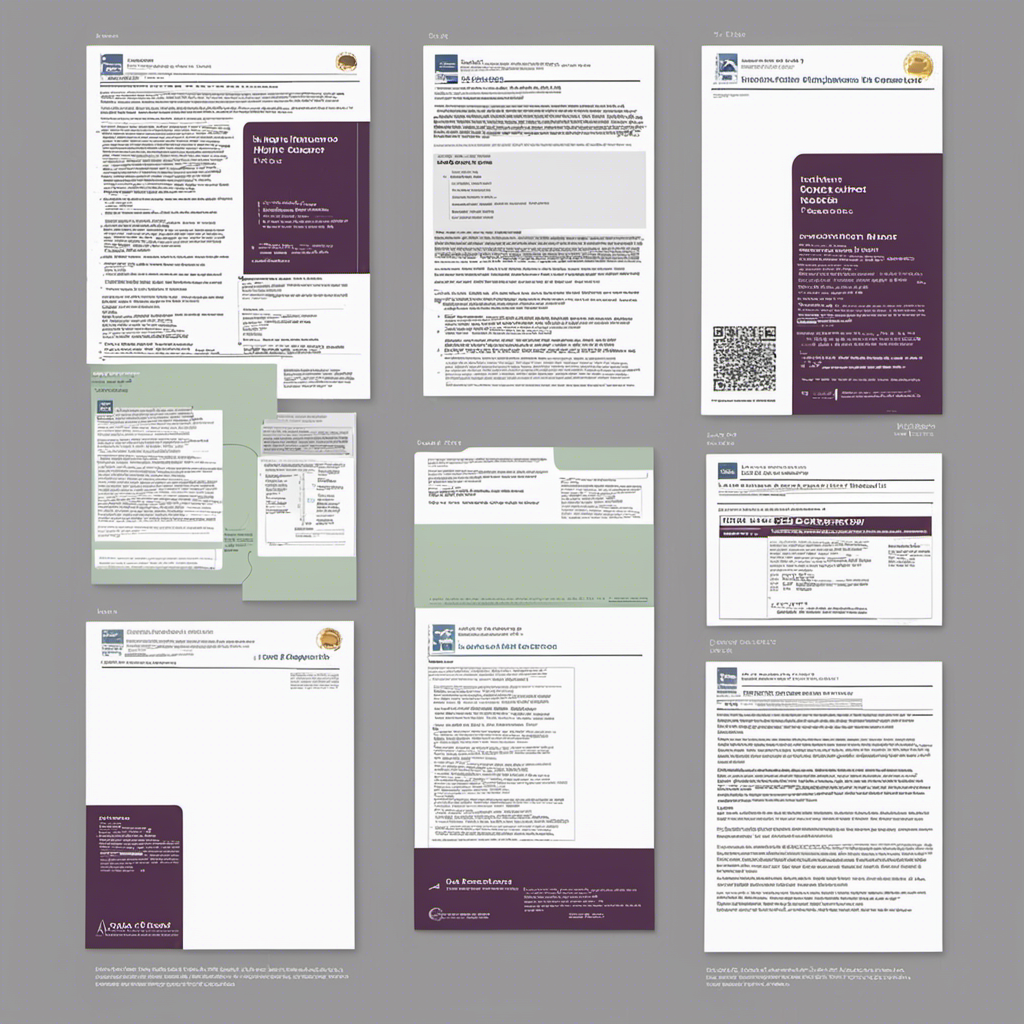

In [45]:
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image